# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

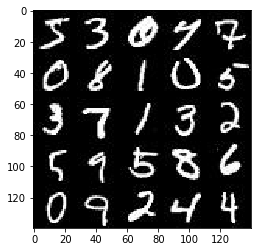

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

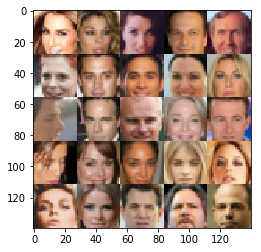

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


//anaconda/envs/udacitydl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name="lr")
    
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    ## same as implemented for house num generation and mnsit using nn
    
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)

    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real, 
                                                labels = tf.ones_like(disc_output_real) * (1 - smooth))
                                                )
    
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake,
                                                labels = tf.zeros_like(disc_output_fake))
                                                )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, 
                                                labels = tf.ones_like(disc_output_fake))
                                                )

    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    })
                
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    })
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
        
    return losses         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


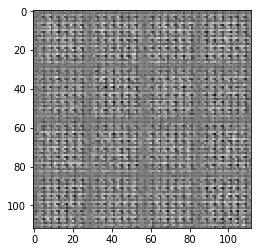

Epoch 1/2... Generator Loss: 3.3604 Discriminator Loss: 0.4139...
Epoch 1/2... Generator Loss: 5.1978 Discriminator Loss: 0.3581...
Epoch 1/2... Generator Loss: 7.4123 Discriminator Loss: 0.4213...
Epoch 1/2... Generator Loss: 5.4180 Discriminator Loss: 0.3532...
Epoch 1/2... Generator Loss: 5.5982 Discriminator Loss: 0.3534...
Epoch 1/2... Generator Loss: 5.1221 Discriminator Loss: 0.3946...
Epoch 1/2... Generator Loss: 4.6414 Discriminator Loss: 0.5183...
Epoch 1/2... Generator Loss: 1.7627 Discriminator Loss: 0.6758...
Epoch 1/2... Generator Loss: 1.4429 Discriminator Loss: 1.4322...
Epoch 1/2... Generator Loss: 1.9651 Discriminator Loss: 0.7333...


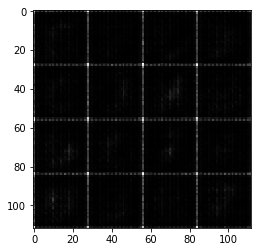

Epoch 1/2... Generator Loss: 2.1252 Discriminator Loss: 0.8932...
Epoch 1/2... Generator Loss: 1.8962 Discriminator Loss: 0.8134...
Epoch 1/2... Generator Loss: 1.1326 Discriminator Loss: 1.1097...
Epoch 1/2... Generator Loss: 0.9540 Discriminator Loss: 1.0810...
Epoch 1/2... Generator Loss: 1.9577 Discriminator Loss: 1.2477...
Epoch 1/2... Generator Loss: 0.4265 Discriminator Loss: 1.7553...
Epoch 1/2... Generator Loss: 1.0520 Discriminator Loss: 1.0292...
Epoch 1/2... Generator Loss: 1.0213 Discriminator Loss: 0.9915...
Epoch 1/2... Generator Loss: 1.4529 Discriminator Loss: 0.9446...
Epoch 1/2... Generator Loss: 1.0819 Discriminator Loss: 1.0705...


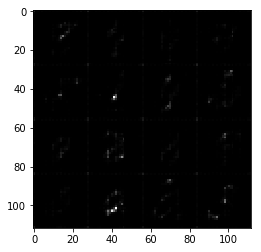

Epoch 1/2... Generator Loss: 1.9614 Discriminator Loss: 1.1099...
Epoch 1/2... Generator Loss: 1.7830 Discriminator Loss: 1.0113...
Epoch 1/2... Generator Loss: 1.0322 Discriminator Loss: 1.0177...
Epoch 1/2... Generator Loss: 1.9331 Discriminator Loss: 0.8431...
Epoch 1/2... Generator Loss: 1.6303 Discriminator Loss: 0.8392...
Epoch 1/2... Generator Loss: 1.6410 Discriminator Loss: 0.9089...
Epoch 1/2... Generator Loss: 2.3382 Discriminator Loss: 0.8758...
Epoch 1/2... Generator Loss: 1.1809 Discriminator Loss: 0.9545...
Epoch 1/2... Generator Loss: 2.1052 Discriminator Loss: 0.9293...
Epoch 1/2... Generator Loss: 1.0501 Discriminator Loss: 1.0097...


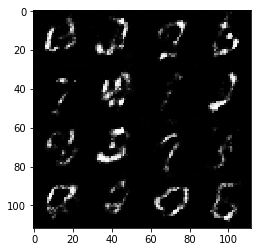

Epoch 1/2... Generator Loss: 1.2503 Discriminator Loss: 0.8500...
Epoch 1/2... Generator Loss: 1.1681 Discriminator Loss: 0.9205...
Epoch 1/2... Generator Loss: 2.3022 Discriminator Loss: 1.0982...
Epoch 1/2... Generator Loss: 1.3864 Discriminator Loss: 1.0160...
Epoch 1/2... Generator Loss: 1.1706 Discriminator Loss: 1.0076...
Epoch 1/2... Generator Loss: 1.2334 Discriminator Loss: 0.9743...
Epoch 1/2... Generator Loss: 2.7524 Discriminator Loss: 1.3389...
Epoch 1/2... Generator Loss: 1.2007 Discriminator Loss: 0.9922...
Epoch 1/2... Generator Loss: 1.3156 Discriminator Loss: 1.0537...
Epoch 1/2... Generator Loss: 2.5944 Discriminator Loss: 1.3974...


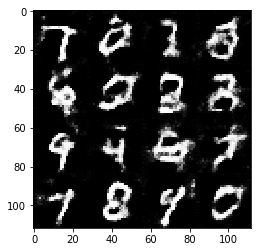

Epoch 1/2... Generator Loss: 1.5328 Discriminator Loss: 1.1023...
Epoch 1/2... Generator Loss: 0.6991 Discriminator Loss: 1.1939...
Epoch 1/2... Generator Loss: 1.7088 Discriminator Loss: 1.1131...
Epoch 1/2... Generator Loss: 1.1603 Discriminator Loss: 0.9804...
Epoch 1/2... Generator Loss: 1.7641 Discriminator Loss: 1.0616...
Epoch 1/2... Generator Loss: 1.4310 Discriminator Loss: 1.0019...
Epoch 2/2... Generator Loss: 1.1873 Discriminator Loss: 1.0403...
Epoch 2/2... Generator Loss: 0.8928 Discriminator Loss: 1.0859...
Epoch 2/2... Generator Loss: 0.9653 Discriminator Loss: 1.0598...
Epoch 2/2... Generator Loss: 0.6921 Discriminator Loss: 1.2357...


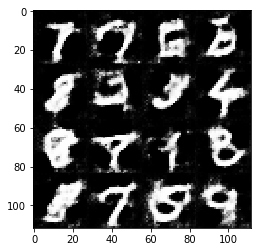

Epoch 2/2... Generator Loss: 1.1857 Discriminator Loss: 0.9116...
Epoch 2/2... Generator Loss: 0.7948 Discriminator Loss: 1.2325...
Epoch 2/2... Generator Loss: 1.2191 Discriminator Loss: 1.0913...
Epoch 2/2... Generator Loss: 0.9896 Discriminator Loss: 1.0711...
Epoch 2/2... Generator Loss: 1.4925 Discriminator Loss: 1.0523...
Epoch 2/2... Generator Loss: 1.2448 Discriminator Loss: 1.0021...
Epoch 2/2... Generator Loss: 0.8390 Discriminator Loss: 1.1340...
Epoch 2/2... Generator Loss: 1.5530 Discriminator Loss: 0.9694...
Epoch 2/2... Generator Loss: 0.9927 Discriminator Loss: 1.1643...
Epoch 2/2... Generator Loss: 0.7563 Discriminator Loss: 1.1342...


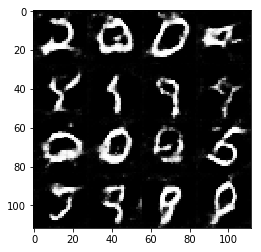

Epoch 2/2... Generator Loss: 0.9445 Discriminator Loss: 1.0654...
Epoch 2/2... Generator Loss: 0.8620 Discriminator Loss: 1.1491...
Epoch 2/2... Generator Loss: 1.2605 Discriminator Loss: 1.0086...
Epoch 2/2... Generator Loss: 0.7679 Discriminator Loss: 1.1391...
Epoch 2/2... Generator Loss: 1.1407 Discriminator Loss: 1.0546...
Epoch 2/2... Generator Loss: 0.7728 Discriminator Loss: 1.2339...
Epoch 2/2... Generator Loss: 1.4348 Discriminator Loss: 1.0270...
Epoch 2/2... Generator Loss: 1.0682 Discriminator Loss: 1.0953...
Epoch 2/2... Generator Loss: 1.3124 Discriminator Loss: 0.9602...
Epoch 2/2... Generator Loss: 1.2709 Discriminator Loss: 0.9900...


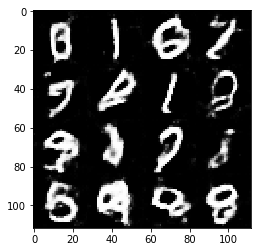

Epoch 2/2... Generator Loss: 1.1290 Discriminator Loss: 1.0335...
Epoch 2/2... Generator Loss: 1.8921 Discriminator Loss: 0.9894...
Epoch 2/2... Generator Loss: 1.4346 Discriminator Loss: 1.0377...
Epoch 2/2... Generator Loss: 1.4544 Discriminator Loss: 1.0211...
Epoch 2/2... Generator Loss: 1.1345 Discriminator Loss: 1.0911...
Epoch 2/2... Generator Loss: 1.2053 Discriminator Loss: 0.9713...
Epoch 2/2... Generator Loss: 0.9958 Discriminator Loss: 1.0246...
Epoch 2/2... Generator Loss: 0.8520 Discriminator Loss: 1.1848...
Epoch 2/2... Generator Loss: 1.3504 Discriminator Loss: 1.0164...
Epoch 2/2... Generator Loss: 1.1647 Discriminator Loss: 1.0188...


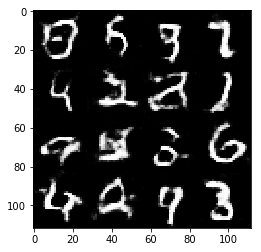

Epoch 2/2... Generator Loss: 0.7145 Discriminator Loss: 1.2625...
Epoch 2/2... Generator Loss: 1.4234 Discriminator Loss: 0.9993...
Epoch 2/2... Generator Loss: 0.8313 Discriminator Loss: 1.1548...
Epoch 2/2... Generator Loss: 1.7416 Discriminator Loss: 1.0284...
Epoch 2/2... Generator Loss: 1.1595 Discriminator Loss: 1.0405...
Epoch 2/2... Generator Loss: 0.9741 Discriminator Loss: 1.0219...
Epoch 2/2... Generator Loss: 1.3317 Discriminator Loss: 0.9720...
Epoch 2/2... Generator Loss: 2.2463 Discriminator Loss: 1.2149...
Epoch 2/2... Generator Loss: 1.8114 Discriminator Loss: 0.9737...
Epoch 2/2... Generator Loss: 1.5933 Discriminator Loss: 1.0764...


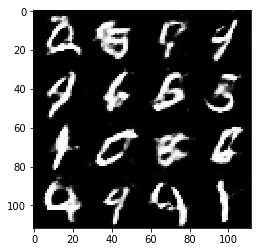

Epoch 2/2... Generator Loss: 0.8511 Discriminator Loss: 1.1288...
Epoch 2/2... Generator Loss: 1.2068 Discriminator Loss: 0.9653...
Epoch 2/2... Generator Loss: 1.1870 Discriminator Loss: 0.9225...


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


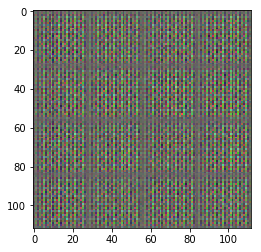

Epoch 1/1... Generator Loss: 2.1660 Discriminator Loss: 0.5935...
Epoch 1/1... Generator Loss: 4.2689 Discriminator Loss: 0.4207...
Epoch 1/1... Generator Loss: 2.6455 Discriminator Loss: 0.8334...
Epoch 1/1... Generator Loss: 0.2297 Discriminator Loss: 2.3666...
Epoch 1/1... Generator Loss: 0.6727 Discriminator Loss: 1.3884...
Epoch 1/1... Generator Loss: 3.0416 Discriminator Loss: 0.7163...
Epoch 1/1... Generator Loss: 3.8757 Discriminator Loss: 0.5711...
Epoch 1/1... Generator Loss: 3.0527 Discriminator Loss: 0.5183...
Epoch 1/1... Generator Loss: 2.7787 Discriminator Loss: 0.5033...
Epoch 1/1... Generator Loss: 2.4701 Discriminator Loss: 0.4873...


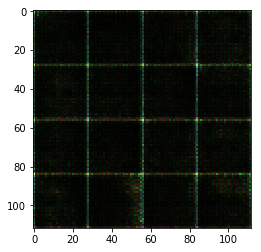

Epoch 1/1... Generator Loss: 3.5111 Discriminator Loss: 0.4376...
Epoch 1/1... Generator Loss: 1.6612 Discriminator Loss: 0.6689...
Epoch 1/1... Generator Loss: 2.0927 Discriminator Loss: 0.5587...
Epoch 1/1... Generator Loss: 0.9869 Discriminator Loss: 1.2750...
Epoch 1/1... Generator Loss: 1.2159 Discriminator Loss: 0.9306...
Epoch 1/1... Generator Loss: 1.7716 Discriminator Loss: 1.0952...
Epoch 1/1... Generator Loss: 0.8134 Discriminator Loss: 1.1590...
Epoch 1/1... Generator Loss: 0.9421 Discriminator Loss: 0.9978...
Epoch 1/1... Generator Loss: 0.9799 Discriminator Loss: 1.0888...
Epoch 1/1... Generator Loss: 2.1116 Discriminator Loss: 1.1273...


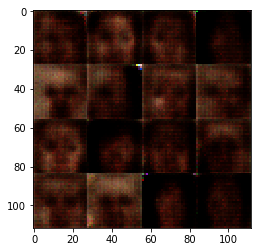

Epoch 1/1... Generator Loss: 2.1627 Discriminator Loss: 1.0094...
Epoch 1/1... Generator Loss: 2.5594 Discriminator Loss: 1.5289...
Epoch 1/1... Generator Loss: 2.0149 Discriminator Loss: 0.8993...
Epoch 1/1... Generator Loss: 0.9160 Discriminator Loss: 1.1371...
Epoch 1/1... Generator Loss: 0.5629 Discriminator Loss: 1.4373...
Epoch 1/1... Generator Loss: 0.7083 Discriminator Loss: 1.3214...
Epoch 1/1... Generator Loss: 1.1877 Discriminator Loss: 1.0889...
Epoch 1/1... Generator Loss: 1.2603 Discriminator Loss: 0.9270...
Epoch 1/1... Generator Loss: 1.4174 Discriminator Loss: 0.9307...
Epoch 1/1... Generator Loss: 0.6282 Discriminator Loss: 1.2485...


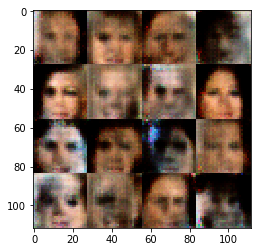

Epoch 1/1... Generator Loss: 1.3984 Discriminator Loss: 1.0442...
Epoch 1/1... Generator Loss: 0.3899 Discriminator Loss: 1.7098...
Epoch 1/1... Generator Loss: 2.3702 Discriminator Loss: 1.3328...
Epoch 1/1... Generator Loss: 3.1231 Discriminator Loss: 1.8094...
Epoch 1/1... Generator Loss: 1.9504 Discriminator Loss: 1.2190...
Epoch 1/1... Generator Loss: 0.4676 Discriminator Loss: 1.6812...
Epoch 1/1... Generator Loss: 1.2837 Discriminator Loss: 1.3656...
Epoch 1/1... Generator Loss: 2.0474 Discriminator Loss: 1.2982...
Epoch 1/1... Generator Loss: 0.9819 Discriminator Loss: 0.9695...
Epoch 1/1... Generator Loss: 0.9965 Discriminator Loss: 0.9718...


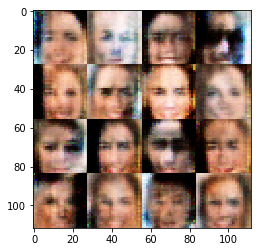

Epoch 1/1... Generator Loss: 2.0601 Discriminator Loss: 1.6825...
Epoch 1/1... Generator Loss: 1.1491 Discriminator Loss: 1.1752...
Epoch 1/1... Generator Loss: 0.7070 Discriminator Loss: 1.2117...
Epoch 1/1... Generator Loss: 0.6775 Discriminator Loss: 1.2375...
Epoch 1/1... Generator Loss: 0.5007 Discriminator Loss: 1.4651...
Epoch 1/1... Generator Loss: 2.9728 Discriminator Loss: 1.9594...
Epoch 1/1... Generator Loss: 1.8763 Discriminator Loss: 1.3485...
Epoch 1/1... Generator Loss: 0.8684 Discriminator Loss: 1.1002...
Epoch 1/1... Generator Loss: 0.9086 Discriminator Loss: 1.0779...
Epoch 1/1... Generator Loss: 0.9015 Discriminator Loss: 1.1773...


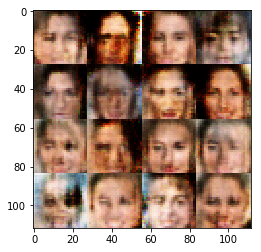

Epoch 1/1... Generator Loss: 1.8169 Discriminator Loss: 1.0793...
Epoch 1/1... Generator Loss: 1.3034 Discriminator Loss: 1.0003...
Epoch 1/1... Generator Loss: 1.1598 Discriminator Loss: 1.2151...
Epoch 1/1... Generator Loss: 0.7954 Discriminator Loss: 1.0808...
Epoch 1/1... Generator Loss: 1.1157 Discriminator Loss: 0.8772...
Epoch 1/1... Generator Loss: 1.9877 Discriminator Loss: 1.3989...
Epoch 1/1... Generator Loss: 0.7707 Discriminator Loss: 1.2694...
Epoch 1/1... Generator Loss: 1.1506 Discriminator Loss: 0.9811...
Epoch 1/1... Generator Loss: 1.1938 Discriminator Loss: 1.1618...
Epoch 1/1... Generator Loss: 1.0202 Discriminator Loss: 1.0494...


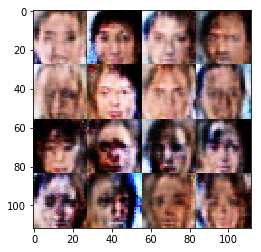

Epoch 1/1... Generator Loss: 1.0264 Discriminator Loss: 1.1679...
Epoch 1/1... Generator Loss: 3.1064 Discriminator Loss: 2.7116...
Epoch 1/1... Generator Loss: 0.7266 Discriminator Loss: 1.1209...
Epoch 1/1... Generator Loss: 1.0598 Discriminator Loss: 1.2184...
Epoch 1/1... Generator Loss: 0.3393 Discriminator Loss: 1.7336...
Epoch 1/1... Generator Loss: 1.2988 Discriminator Loss: 0.7743...
Epoch 1/1... Generator Loss: 0.5941 Discriminator Loss: 1.3911...
Epoch 1/1... Generator Loss: 1.0520 Discriminator Loss: 1.4142...
Epoch 1/1... Generator Loss: 0.7197 Discriminator Loss: 1.2618...
Epoch 1/1... Generator Loss: 0.6816 Discriminator Loss: 1.3956...


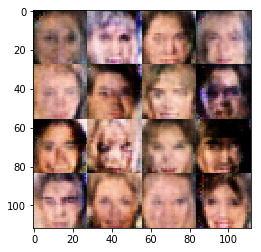

Epoch 1/1... Generator Loss: 1.1875 Discriminator Loss: 1.2239...
Epoch 1/1... Generator Loss: 1.0042 Discriminator Loss: 1.0734...
Epoch 1/1... Generator Loss: 0.8894 Discriminator Loss: 1.1205...
Epoch 1/1... Generator Loss: 0.9480 Discriminator Loss: 1.2117...
Epoch 1/1... Generator Loss: 1.3619 Discriminator Loss: 1.2123...
Epoch 1/1... Generator Loss: 1.2483 Discriminator Loss: 1.2498...
Epoch 1/1... Generator Loss: 0.9412 Discriminator Loss: 1.2525...
Epoch 1/1... Generator Loss: 1.0575 Discriminator Loss: 1.2281...
Epoch 1/1... Generator Loss: 0.7440 Discriminator Loss: 1.3010...
Epoch 1/1... Generator Loss: 0.8034 Discriminator Loss: 1.2486...


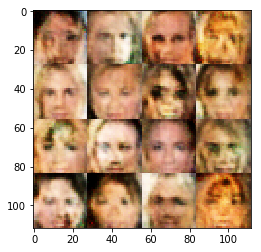

Epoch 1/1... Generator Loss: 1.1414 Discriminator Loss: 1.3686...
Epoch 1/1... Generator Loss: 0.9127 Discriminator Loss: 1.2705...
Epoch 1/1... Generator Loss: 1.0985 Discriminator Loss: 1.5137...
Epoch 1/1... Generator Loss: 0.7950 Discriminator Loss: 1.4098...
Epoch 1/1... Generator Loss: 0.7465 Discriminator Loss: 1.3669...
Epoch 1/1... Generator Loss: 0.7626 Discriminator Loss: 1.3091...
Epoch 1/1... Generator Loss: 0.9292 Discriminator Loss: 1.2003...
Epoch 1/1... Generator Loss: 0.9520 Discriminator Loss: 1.3773...
Epoch 1/1... Generator Loss: 0.8785 Discriminator Loss: 1.3605...
Epoch 1/1... Generator Loss: 0.7471 Discriminator Loss: 1.3914...


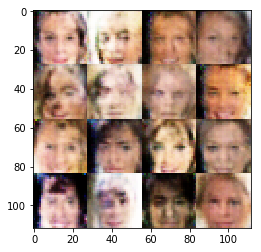

Epoch 1/1... Generator Loss: 1.1666 Discriminator Loss: 1.2924...
Epoch 1/1... Generator Loss: 0.7065 Discriminator Loss: 1.5011...
Epoch 1/1... Generator Loss: 0.8017 Discriminator Loss: 1.2222...
Epoch 1/1... Generator Loss: 0.9155 Discriminator Loss: 1.2053...
Epoch 1/1... Generator Loss: 1.2898 Discriminator Loss: 1.3089...
Epoch 1/1... Generator Loss: 0.6591 Discriminator Loss: 1.3061...
Epoch 1/1... Generator Loss: 0.7414 Discriminator Loss: 1.2635...
Epoch 1/1... Generator Loss: 0.5749 Discriminator Loss: 1.4160...
Epoch 1/1... Generator Loss: 1.4282 Discriminator Loss: 1.3719...
Epoch 1/1... Generator Loss: 1.0758 Discriminator Loss: 1.3576...


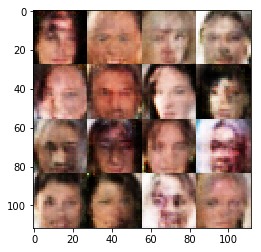

Epoch 1/1... Generator Loss: 1.1409 Discriminator Loss: 1.2149...
Epoch 1/1... Generator Loss: 0.8478 Discriminator Loss: 1.4067...
Epoch 1/1... Generator Loss: 0.4902 Discriminator Loss: 1.5394...
Epoch 1/1... Generator Loss: 0.9631 Discriminator Loss: 1.2005...
Epoch 1/1... Generator Loss: 0.9857 Discriminator Loss: 1.1915...
Epoch 1/1... Generator Loss: 0.6324 Discriminator Loss: 1.4463...
Epoch 1/1... Generator Loss: 0.6501 Discriminator Loss: 1.3957...
Epoch 1/1... Generator Loss: 0.9532 Discriminator Loss: 1.2737...
Epoch 1/1... Generator Loss: 0.6743 Discriminator Loss: 1.2881...
Epoch 1/1... Generator Loss: 0.7513 Discriminator Loss: 1.3232...


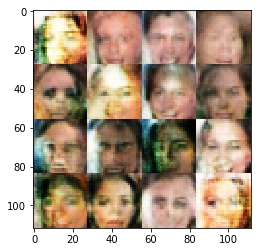

Epoch 1/1... Generator Loss: 0.6727 Discriminator Loss: 1.3342...
Epoch 1/1... Generator Loss: 1.1071 Discriminator Loss: 1.3521...
Epoch 1/1... Generator Loss: 0.6889 Discriminator Loss: 1.3154...
Epoch 1/1... Generator Loss: 1.1773 Discriminator Loss: 1.2695...
Epoch 1/1... Generator Loss: 0.8199 Discriminator Loss: 1.2928...
Epoch 1/1... Generator Loss: 1.0737 Discriminator Loss: 1.3185...
Epoch 1/1... Generator Loss: 0.9294 Discriminator Loss: 1.3503...
Epoch 1/1... Generator Loss: 0.5710 Discriminator Loss: 1.4222...
Epoch 1/1... Generator Loss: 0.6689 Discriminator Loss: 1.4784...
Epoch 1/1... Generator Loss: 0.8215 Discriminator Loss: 1.3773...


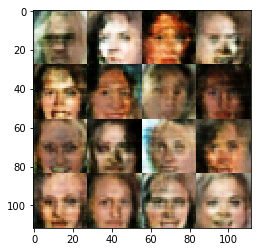

Epoch 1/1... Generator Loss: 1.1053 Discriminator Loss: 1.2157...
Epoch 1/1... Generator Loss: 0.8754 Discriminator Loss: 1.2373...
Epoch 1/1... Generator Loss: 0.8120 Discriminator Loss: 1.2470...
Epoch 1/1... Generator Loss: 0.6849 Discriminator Loss: 1.2241...
Epoch 1/1... Generator Loss: 0.8057 Discriminator Loss: 1.3310...
Epoch 1/1... Generator Loss: 0.9193 Discriminator Loss: 1.3040...
Epoch 1/1... Generator Loss: 0.7260 Discriminator Loss: 1.3525...
Epoch 1/1... Generator Loss: 0.5913 Discriminator Loss: 1.3227...
Epoch 1/1... Generator Loss: 0.8431 Discriminator Loss: 1.3025...
Epoch 1/1... Generator Loss: 0.5393 Discriminator Loss: 1.5191...


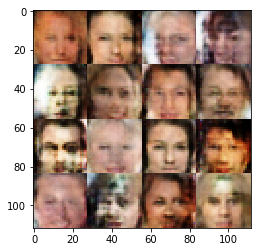

Epoch 1/1... Generator Loss: 0.6831 Discriminator Loss: 1.3987...
Epoch 1/1... Generator Loss: 0.5105 Discriminator Loss: 1.5184...
Epoch 1/1... Generator Loss: 0.9526 Discriminator Loss: 1.1729...
Epoch 1/1... Generator Loss: 0.6566 Discriminator Loss: 1.3741...
Epoch 1/1... Generator Loss: 0.4674 Discriminator Loss: 1.5164...
Epoch 1/1... Generator Loss: 0.9232 Discriminator Loss: 1.2450...
Epoch 1/1... Generator Loss: 0.7414 Discriminator Loss: 1.3783...
Epoch 1/1... Generator Loss: 0.7596 Discriminator Loss: 1.2603...
Epoch 1/1... Generator Loss: 0.9185 Discriminator Loss: 1.2677...
Epoch 1/1... Generator Loss: 0.9404 Discriminator Loss: 1.2599...


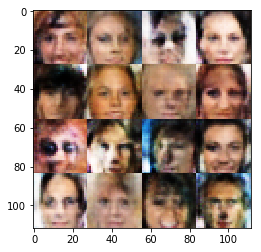

Epoch 1/1... Generator Loss: 0.6836 Discriminator Loss: 1.3463...
Epoch 1/1... Generator Loss: 0.7924 Discriminator Loss: 1.3147...
Epoch 1/1... Generator Loss: 1.0041 Discriminator Loss: 1.1845...
Epoch 1/1... Generator Loss: 0.7286 Discriminator Loss: 1.2875...
Epoch 1/1... Generator Loss: 0.5588 Discriminator Loss: 1.3504...
Epoch 1/1... Generator Loss: 0.7917 Discriminator Loss: 1.3421...
Epoch 1/1... Generator Loss: 0.9091 Discriminator Loss: 1.2475...
Epoch 1/1... Generator Loss: 0.7597 Discriminator Loss: 1.4427...
Epoch 1/1... Generator Loss: 0.9450 Discriminator Loss: 1.2515...
Epoch 1/1... Generator Loss: 0.7637 Discriminator Loss: 1.3323...


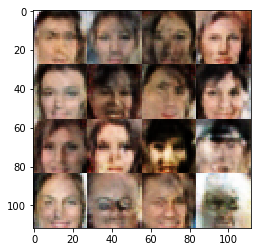

Epoch 1/1... Generator Loss: 0.7621 Discriminator Loss: 1.3104...
Epoch 1/1... Generator Loss: 1.0034 Discriminator Loss: 1.2587...
Epoch 1/1... Generator Loss: 0.7326 Discriminator Loss: 1.3721...
Epoch 1/1... Generator Loss: 1.1609 Discriminator Loss: 1.1589...
Epoch 1/1... Generator Loss: 1.0078 Discriminator Loss: 1.4052...
Epoch 1/1... Generator Loss: 0.8073 Discriminator Loss: 1.2704...
Epoch 1/1... Generator Loss: 0.8716 Discriminator Loss: 1.3270...
Epoch 1/1... Generator Loss: 0.8246 Discriminator Loss: 1.2153...
Epoch 1/1... Generator Loss: 0.7821 Discriminator Loss: 1.3919...
Epoch 1/1... Generator Loss: 0.9332 Discriminator Loss: 1.3129...


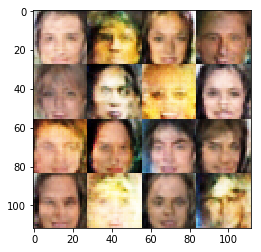

Epoch 1/1... Generator Loss: 0.7226 Discriminator Loss: 1.2781...
Epoch 1/1... Generator Loss: 1.0527 Discriminator Loss: 1.2497...
Epoch 1/1... Generator Loss: 0.6754 Discriminator Loss: 1.2586...
Epoch 1/1... Generator Loss: 0.6782 Discriminator Loss: 1.3814...
Epoch 1/1... Generator Loss: 0.8750 Discriminator Loss: 1.1911...
Epoch 1/1... Generator Loss: 0.7192 Discriminator Loss: 1.4606...
Epoch 1/1... Generator Loss: 0.6523 Discriminator Loss: 1.5024...
Epoch 1/1... Generator Loss: 0.8102 Discriminator Loss: 1.3670...
Epoch 1/1... Generator Loss: 0.9234 Discriminator Loss: 1.1537...
Epoch 1/1... Generator Loss: 0.7771 Discriminator Loss: 1.3976...


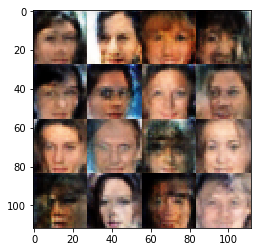

Epoch 1/1... Generator Loss: 0.9104 Discriminator Loss: 1.1535...
Epoch 1/1... Generator Loss: 0.7517 Discriminator Loss: 1.2966...
Epoch 1/1... Generator Loss: 1.1051 Discriminator Loss: 1.2591...
Epoch 1/1... Generator Loss: 0.7524 Discriminator Loss: 1.3395...
Epoch 1/1... Generator Loss: 1.0188 Discriminator Loss: 1.2910...
Epoch 1/1... Generator Loss: 0.9206 Discriminator Loss: 1.3697...
Epoch 1/1... Generator Loss: 0.7959 Discriminator Loss: 1.3735...
Epoch 1/1... Generator Loss: 0.6920 Discriminator Loss: 1.3505...
Epoch 1/1... Generator Loss: 0.8679 Discriminator Loss: 1.2910...
Epoch 1/1... Generator Loss: 1.0426 Discriminator Loss: 1.3322...


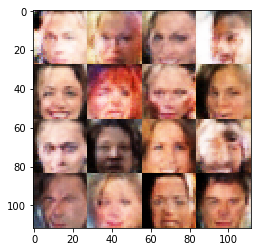

Epoch 1/1... Generator Loss: 0.6907 Discriminator Loss: 1.4164...
Epoch 1/1... Generator Loss: 0.6985 Discriminator Loss: 1.4498...
Epoch 1/1... Generator Loss: 1.1812 Discriminator Loss: 1.2158...
Epoch 1/1... Generator Loss: 0.7228 Discriminator Loss: 1.2391...
Epoch 1/1... Generator Loss: 0.6037 Discriminator Loss: 1.3843...
Epoch 1/1... Generator Loss: 0.9608 Discriminator Loss: 1.2610...
Epoch 1/1... Generator Loss: 0.6281 Discriminator Loss: 1.3614...
Epoch 1/1... Generator Loss: 0.9037 Discriminator Loss: 1.3576...
Epoch 1/1... Generator Loss: 0.8984 Discriminator Loss: 1.3010...
Epoch 1/1... Generator Loss: 0.8030 Discriminator Loss: 1.2898...


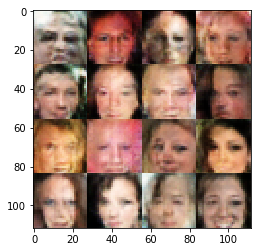

Epoch 1/1... Generator Loss: 0.7633 Discriminator Loss: 1.3522...
Epoch 1/1... Generator Loss: 0.6151 Discriminator Loss: 1.3535...
Epoch 1/1... Generator Loss: 0.8284 Discriminator Loss: 1.3162...
Epoch 1/1... Generator Loss: 0.9080 Discriminator Loss: 1.3073...
Epoch 1/1... Generator Loss: 0.7419 Discriminator Loss: 1.3692...
Epoch 1/1... Generator Loss: 0.8083 Discriminator Loss: 1.2639...
Epoch 1/1... Generator Loss: 0.5476 Discriminator Loss: 1.4198...
Epoch 1/1... Generator Loss: 0.7612 Discriminator Loss: 1.2287...
Epoch 1/1... Generator Loss: 0.6662 Discriminator Loss: 1.3575...
Epoch 1/1... Generator Loss: 1.0306 Discriminator Loss: 1.2868...


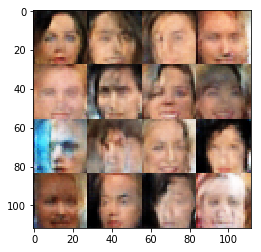

Epoch 1/1... Generator Loss: 0.8808 Discriminator Loss: 1.2665...
Epoch 1/1... Generator Loss: 0.7548 Discriminator Loss: 1.3195...
Epoch 1/1... Generator Loss: 0.8564 Discriminator Loss: 1.3123...
Epoch 1/1... Generator Loss: 0.8607 Discriminator Loss: 1.3267...
Epoch 1/1... Generator Loss: 0.8933 Discriminator Loss: 1.2601...
Epoch 1/1... Generator Loss: 0.7495 Discriminator Loss: 1.3731...
Epoch 1/1... Generator Loss: 0.6337 Discriminator Loss: 1.3594...
Epoch 1/1... Generator Loss: 0.7823 Discriminator Loss: 1.3163...
Epoch 1/1... Generator Loss: 0.5209 Discriminator Loss: 1.5139...
Epoch 1/1... Generator Loss: 0.7185 Discriminator Loss: 1.3752...


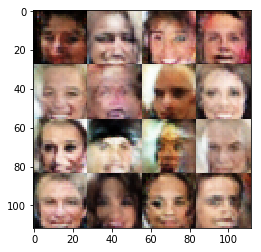

Epoch 1/1... Generator Loss: 0.5855 Discriminator Loss: 1.4576...
Epoch 1/1... Generator Loss: 0.8252 Discriminator Loss: 1.2522...
Epoch 1/1... Generator Loss: 0.7669 Discriminator Loss: 1.3022...
Epoch 1/1... Generator Loss: 0.7551 Discriminator Loss: 1.3329...
Epoch 1/1... Generator Loss: 0.8921 Discriminator Loss: 1.2631...
Epoch 1/1... Generator Loss: 0.7521 Discriminator Loss: 1.2565...
Epoch 1/1... Generator Loss: 0.9079 Discriminator Loss: 1.3330...
Epoch 1/1... Generator Loss: 0.9346 Discriminator Loss: 1.3356...
Epoch 1/1... Generator Loss: 0.7082 Discriminator Loss: 1.3732...
Epoch 1/1... Generator Loss: 0.9439 Discriminator Loss: 1.3443...


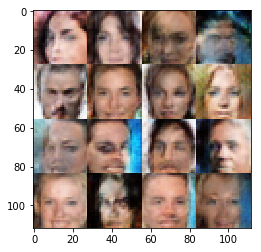

Epoch 1/1... Generator Loss: 0.7154 Discriminator Loss: 1.3205...
Epoch 1/1... Generator Loss: 0.7553 Discriminator Loss: 1.4123...
Epoch 1/1... Generator Loss: 0.9237 Discriminator Loss: 1.3410...
Epoch 1/1... Generator Loss: 0.8117 Discriminator Loss: 1.3387...
Epoch 1/1... Generator Loss: 0.9898 Discriminator Loss: 1.2754...
Epoch 1/1... Generator Loss: 0.8632 Discriminator Loss: 1.2838...
Epoch 1/1... Generator Loss: 0.6854 Discriminator Loss: 1.3419...
Epoch 1/1... Generator Loss: 0.7209 Discriminator Loss: 1.4643...
Epoch 1/1... Generator Loss: 1.1439 Discriminator Loss: 1.1759...
Epoch 1/1... Generator Loss: 0.8839 Discriminator Loss: 1.1650...


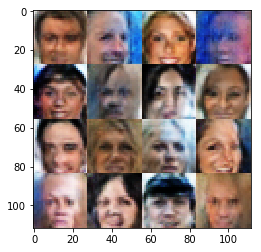

Epoch 1/1... Generator Loss: 0.8220 Discriminator Loss: 1.3997...
Epoch 1/1... Generator Loss: 0.7952 Discriminator Loss: 1.2033...
Epoch 1/1... Generator Loss: 0.7581 Discriminator Loss: 1.3395...
Epoch 1/1... Generator Loss: 0.7441 Discriminator Loss: 1.3923...
Epoch 1/1... Generator Loss: 0.8496 Discriminator Loss: 1.2730...
Epoch 1/1... Generator Loss: 0.7177 Discriminator Loss: 1.3548...
Epoch 1/1... Generator Loss: 0.7193 Discriminator Loss: 1.4054...
Epoch 1/1... Generator Loss: 0.9251 Discriminator Loss: 1.2233...
Epoch 1/1... Generator Loss: 0.7504 Discriminator Loss: 1.4954...
Epoch 1/1... Generator Loss: 0.8373 Discriminator Loss: 1.3211...


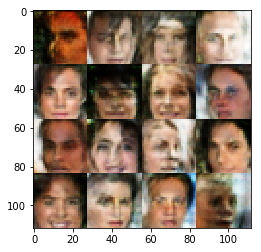

Epoch 1/1... Generator Loss: 0.9151 Discriminator Loss: 1.2346...
Epoch 1/1... Generator Loss: 0.7065 Discriminator Loss: 1.3049...
Epoch 1/1... Generator Loss: 0.8478 Discriminator Loss: 1.2525...
Epoch 1/1... Generator Loss: 0.9017 Discriminator Loss: 1.3864...
Epoch 1/1... Generator Loss: 1.0064 Discriminator Loss: 1.2578...
Epoch 1/1... Generator Loss: 0.9264 Discriminator Loss: 1.2010...
Epoch 1/1... Generator Loss: 0.7267 Discriminator Loss: 1.3606...
Epoch 1/1... Generator Loss: 0.7068 Discriminator Loss: 1.3591...
Epoch 1/1... Generator Loss: 0.9304 Discriminator Loss: 1.2885...
Epoch 1/1... Generator Loss: 0.7149 Discriminator Loss: 1.3260...


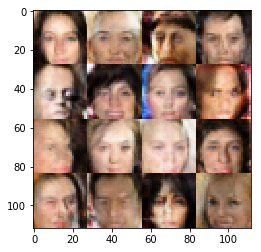

Epoch 1/1... Generator Loss: 0.8609 Discriminator Loss: 1.2816...
Epoch 1/1... Generator Loss: 0.7828 Discriminator Loss: 1.3527...
Epoch 1/1... Generator Loss: 0.7940 Discriminator Loss: 1.3470...
Epoch 1/1... Generator Loss: 0.8789 Discriminator Loss: 1.2462...
Epoch 1/1... Generator Loss: 0.7335 Discriminator Loss: 1.3768...
Epoch 1/1... Generator Loss: 0.8141 Discriminator Loss: 1.3157...
Epoch 1/1... Generator Loss: 0.7686 Discriminator Loss: 1.3974...
Epoch 1/1... Generator Loss: 1.0407 Discriminator Loss: 1.3650...
Epoch 1/1... Generator Loss: 0.7542 Discriminator Loss: 1.3821...
Epoch 1/1... Generator Loss: 0.5725 Discriminator Loss: 1.3858...


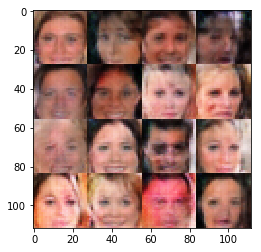

Epoch 1/1... Generator Loss: 0.8763 Discriminator Loss: 1.4116...
Epoch 1/1... Generator Loss: 0.7841 Discriminator Loss: 1.4346...
Epoch 1/1... Generator Loss: 0.7844 Discriminator Loss: 1.2890...
Epoch 1/1... Generator Loss: 0.7554 Discriminator Loss: 1.2509...
Epoch 1/1... Generator Loss: 0.6026 Discriminator Loss: 1.3866...
Epoch 1/1... Generator Loss: 0.6877 Discriminator Loss: 1.5212...
Epoch 1/1... Generator Loss: 0.8185 Discriminator Loss: 1.3954...
Epoch 1/1... Generator Loss: 1.0055 Discriminator Loss: 1.2238...
Epoch 1/1... Generator Loss: 0.7385 Discriminator Loss: 1.3081...
Epoch 1/1... Generator Loss: 0.9268 Discriminator Loss: 1.2635...


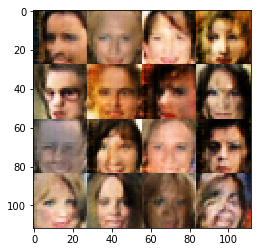

Epoch 1/1... Generator Loss: 0.7419 Discriminator Loss: 1.3085...
Epoch 1/1... Generator Loss: 0.6914 Discriminator Loss: 1.3489...
Epoch 1/1... Generator Loss: 0.7375 Discriminator Loss: 1.3031...
Epoch 1/1... Generator Loss: 0.9865 Discriminator Loss: 1.2095...
Epoch 1/1... Generator Loss: 0.7959 Discriminator Loss: 1.2486...
Epoch 1/1... Generator Loss: 0.8856 Discriminator Loss: 1.3302...
Epoch 1/1... Generator Loss: 0.8250 Discriminator Loss: 1.2647...
Epoch 1/1... Generator Loss: 1.0390 Discriminator Loss: 1.3259...
Epoch 1/1... Generator Loss: 0.7260 Discriminator Loss: 1.3771...
Epoch 1/1... Generator Loss: 0.7773 Discriminator Loss: 1.3379...


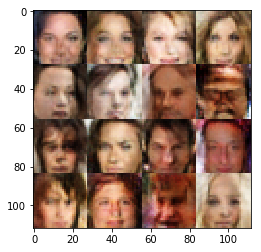

Epoch 1/1... Generator Loss: 0.6007 Discriminator Loss: 1.4826...
Epoch 1/1... Generator Loss: 0.7874 Discriminator Loss: 1.2654...
Epoch 1/1... Generator Loss: 0.6598 Discriminator Loss: 1.4064...
Epoch 1/1... Generator Loss: 0.7095 Discriminator Loss: 1.3519...
Epoch 1/1... Generator Loss: 0.8213 Discriminator Loss: 1.2323...
Epoch 1/1... Generator Loss: 0.8537 Discriminator Loss: 1.3063...
Epoch 1/1... Generator Loss: 0.8154 Discriminator Loss: 1.2102...
Epoch 1/1... Generator Loss: 1.0506 Discriminator Loss: 1.2386...
Epoch 1/1... Generator Loss: 0.8009 Discriminator Loss: 1.3047...
Epoch 1/1... Generator Loss: 0.7734 Discriminator Loss: 1.4092...


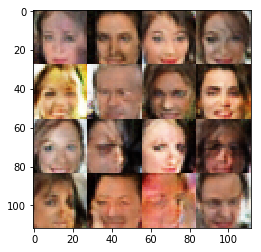

Epoch 1/1... Generator Loss: 0.7367 Discriminator Loss: 1.3086...
Epoch 1/1... Generator Loss: 0.8519 Discriminator Loss: 1.3298...
Epoch 1/1... Generator Loss: 0.9439 Discriminator Loss: 1.4159...
Epoch 1/1... Generator Loss: 0.8807 Discriminator Loss: 1.2138...
Epoch 1/1... Generator Loss: 0.7967 Discriminator Loss: 1.2504...
Epoch 1/1... Generator Loss: 1.0340 Discriminator Loss: 1.1059...
Epoch 1/1... Generator Loss: 0.8203 Discriminator Loss: 1.2676...
Epoch 1/1... Generator Loss: 0.8786 Discriminator Loss: 1.2956...
Epoch 1/1... Generator Loss: 0.9381 Discriminator Loss: 1.3009...
Epoch 1/1... Generator Loss: 0.6910 Discriminator Loss: 1.3102...


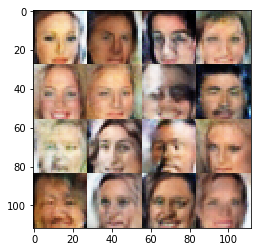

Epoch 1/1... Generator Loss: 0.8525 Discriminator Loss: 1.2516...
Epoch 1/1... Generator Loss: 0.8198 Discriminator Loss: 1.3141...
Epoch 1/1... Generator Loss: 0.8853 Discriminator Loss: 1.2867...
Epoch 1/1... Generator Loss: 0.6571 Discriminator Loss: 1.3495...
Epoch 1/1... Generator Loss: 0.9319 Discriminator Loss: 1.2267...
Epoch 1/1... Generator Loss: 0.8180 Discriminator Loss: 1.4158...
Epoch 1/1... Generator Loss: 0.8262 Discriminator Loss: 1.2481...
Epoch 1/1... Generator Loss: 0.9756 Discriminator Loss: 1.2563...
Epoch 1/1... Generator Loss: 0.7522 Discriminator Loss: 1.4200...
Epoch 1/1... Generator Loss: 0.7053 Discriminator Loss: 1.3778...


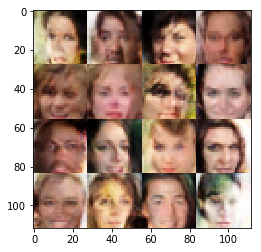

Epoch 1/1... Generator Loss: 0.7506 Discriminator Loss: 1.2732...
Epoch 1/1... Generator Loss: 0.9741 Discriminator Loss: 1.1847...
Epoch 1/1... Generator Loss: 0.8637 Discriminator Loss: 1.2384...
Epoch 1/1... Generator Loss: 0.8325 Discriminator Loss: 1.3425...
Epoch 1/1... Generator Loss: 0.7561 Discriminator Loss: 1.3577...
Epoch 1/1... Generator Loss: 0.8266 Discriminator Loss: 1.4330...


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.